FOR THE DATASET, VISIT: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset 

**IMPORT LIBRARIES AND SET SEED**

In [1]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import random 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.parallel import DistributedDataParallel as DDP

In [2]:
# Set seed for the project 
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
set_seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**PREPROCESSING DATASET**

In [3]:
data_root = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'
img_paths, labels = [], []
classes = {
    label_idx: class_name for label_idx, class_name in enumerate(sorted(os.listdir(data_root)))
}

In [4]:
# Use os.walk to traverse the directory
img_paths, labels = [], []
image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp') # Define extensions once

for label_idx, class_name in classes.items():
    class_dir = os.path.join(data_root, class_name)
    if os.path.isdir(class_dir):
        # Use os.walk to traverse the directory and its subdirectories
        for dirpath, _, filenames in os.walk(class_dir):
            for filename in filenames:
                # Check for file extension and if it's a file
                if filename.lower().endswith(image_extensions):
                    item_path = os.path.join(dirpath, filename)
                    img_paths.append(item_path)
                    labels.append(label_idx)
    else:
        print(f"Warning: Directory not found or not a directory: {class_dir}")

**TRAIN/VAL/TEST SPLIT**

In [5]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

# Training dataset
X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size = val_size,
    random_state = seed,
    shuffle = is_shuffle
)

# Testing dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size = test_size,
    random_state = seed,
    shuffle = is_shuffle
)

**PYTORCH DATASET**

In [6]:
class RiceCls(nn.Module):
    def __init__(self, X, y, transform = None):
        self.img_paths = X
        self.labels = y
        self.transform = transform
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

**NORMALIZE INPUTS SIZE**

In [7]:
def transform(img, img_size = (224,224)):
    # Make sure every image has the same size
    img = img.resize(img_size)
    
    # Consider RGB color
    img = np.array(img)[...,:3]
    
    # Convert image from (height, width, channel) to (channel, height, width)
    # After that, convert to float type for using torch
    img = torch.tensor(img).permute(2,0,1).float()
    
    # Normalization
    img_norm = img/255.0
    return img_norm

**DATALOADER**

In [8]:
train_dataset = RiceCls(
    X_train, y_train,
    transform = transform
)

val_dataset = RiceCls(
    X_val, y_val,
    transform = transform
)

test_dataset = RiceCls(
    X_test, y_test,
    transform = transform
)

In [9]:
train_batch_size = 256
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size = train_batch_size,
    shuffle = True,
    num_workers = 8
)

val_loader = DataLoader(
    val_dataset,
    batch_size = test_batch_size,
    shuffle = False,
    num_workers = 8
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    num_workers = 8
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Feature batch shape: torch.Size([256, 3, 224, 224])
Labels batch shape: torch.Size([256])


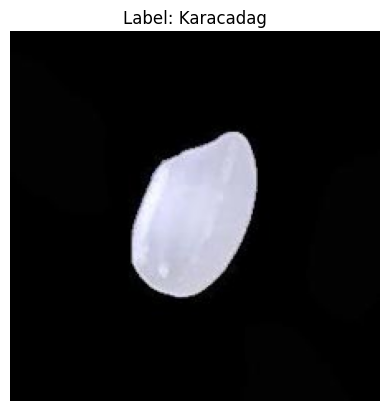

In [10]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].permute(1, 2, 0)
label = train_labels[0].item()
plt.imshow(img)
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

**MODEL - RESNET**

In [11]:
# In this problem, we implement the custom ResNet model
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1
        )
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1
        )
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = stride),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = x.clone()
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x += self.downsample(shortcut)
        x = self.relu(x)
        
        return x

In [12]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels = 3, out_channels = 64, kernel_size = 7, stride = 2, padding = 3
        )
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(
            kernel_size = 3, stride = 2, padding = 1
        )
        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(512, n_classes)

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)
        
        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride = 1)
            blocks.append(block)

        block_sequential = nn.Sequential(*blocks)

        return block_sequential

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc_1(x)

        return x

In [13]:
# We use ResNet-18 for this project
n_classes = len(list(classes.keys()))
model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2, 2, 2, 2],
    n_classes=n_classes
).to(device)

# We utilize both GPU T4
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPU!")
    model = nn.DataParallel(model)

Using 2 GPU!


In [14]:
model.eval()

dummy_tensor = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([1, 6])


**CUSTOM FUNCTIONS**

In [15]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

In [16]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [17]:
lr = 2e-4
epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [18]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 1.4585	Val loss: 1.1940
EPOCH 2:	Train loss: 1.0744	Val loss: 0.9542
EPOCH 3:	Train loss: 0.8848	Val loss: 0.7850
EPOCH 4:	Train loss: 0.7318	Val loss: 0.6621
EPOCH 5:	Train loss: 0.6178	Val loss: 0.5610
EPOCH 6:	Train loss: 0.5271	Val loss: 0.4737
EPOCH 7:	Train loss: 0.4552	Val loss: 0.4228
EPOCH 8:	Train loss: 0.3975	Val loss: 0.4331
EPOCH 9:	Train loss: 0.3446	Val loss: 0.3835
EPOCH 10:	Train loss: 0.2952	Val loss: 0.3076


**PLOTTING LOSSES**

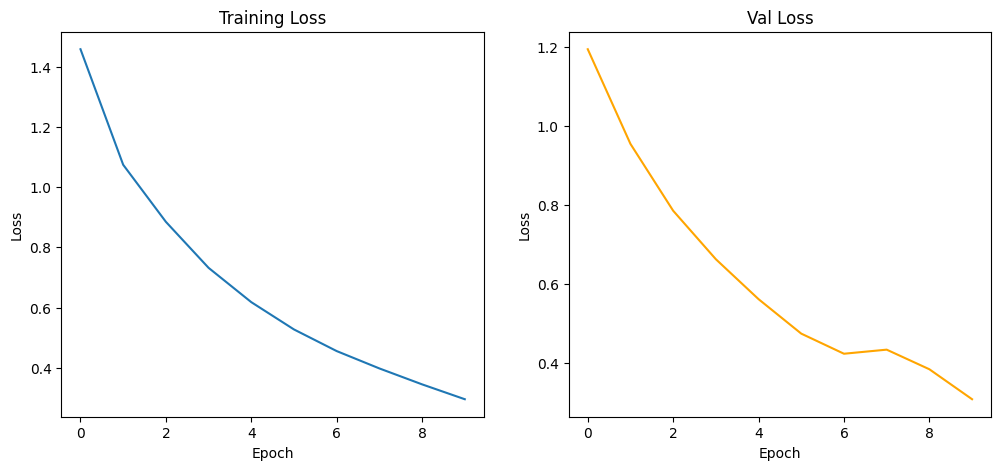

In [19]:
# Plotting the training and validating losses
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Training losses
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

# Validating losses
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

**EVALUATE THE MODEL**

In [20]:
# Evaluate the model
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.9330666666666667
Test accuracy:  0.9274666666666667
